```{note}
This repository and interactive notebook are intended to support a feature article for the Tech & Racial Justice collaborative newsletter.

This notebook and the related article contain analyses of emergency events and discuss topics such as gunfire, domestic abuse, and other forms of violence including police brutality and neglect.

Readers are advised to take care and use discretion.
```

# Setup

In [1]:
# dependencies
import yaml
import pandas as pd
import matplotlib.pyplot as plt

In [21]:
# support methods
def readyaml(fname):
    """
    Reads a yaml file and returns the contents.
    """
    with open(fname, 'r') as f:
        data = yaml.safe_load(f)
    return data


def get_colinfo(ser, nrows):
    info = {
        'sample': ser.sample().values[0],
        'nunique': len(ser.unique()),
        'nreported': ser.notna().sum(),
    }
    info['propunique'] = info['nunique']/nrows
    info['percunique'] = info['propunique']*100
    info['propreported'] = info['nreported']/nrows
    info['percreported'] = info['propreported']*100
    return info


def get_condinfo(df):
    """
    Computes several descriptive statistics using `df` records where `patt` appears in `init_type`. \n
    When looking for reclassifications, checks for `patt` in `init_type` but not in `fin_type`.
    """
    info = {}
    info['n_total'] = df.shape[0]
    info['n_missing_dispatch'] = (df.disp_date.isna()).sum()
    info['n_disp_under_30min'] = (df.time_to_arrive < pd.Timedelta(minutes=30)).sum()
    info['n_disp_under_2hrs'] = (df.time_to_arrive < pd.Timedelta(minutes=120)).sum()
    info['n_disp_under_6hrs'] = (df.time_to_arrive < pd.Timedelta(minutes=360)).sum()
    info['n_priority_1A'] = (df.init_priority == '1A').sum()
    info['n_priority1A_missdisp'] = ((df.init_priority == '1A') & (df.disp_date.isna())).sum()
    info['n_priority1A_disp_under30'] = ((df.init_priority == '1A') & (df.time_to_arrive < pd.Timedelta(minutes=30))).sum()
    info['n_reclassified'] = (df.init_type != df.fin_type).sum()
    return info


def add_props(df, n_allevents):
    """
    Adds proportions by all events and by group total for computations derived from keyword searching.
    """
    calcs = [col.replace('n_', '') for col in df.columns]
    df['prop_all_events'] = df['n_total'] / n_allevents
    for calc in calcs:
        if calc == 'total': continue
        df[f'prop_{calc}'] = df[f'n_{calc}'] / df['n_total']
    return df

In [3]:
# main
oemc_disp = pd.read_parquet("../../data/export/output/oemc_dispatch.parquet")
magic = pd.read_parquet("../../data/export/output/keyphrase_magic.parquet")
rawfields = readyaml("../../data/import/hand/fields.yml")
keyphrases = readyaml("../../data/shared/hand/keywords.yml")

In [4]:
corecols = rawfields.keys()
ncols = [col for col in magic.columns if 'n_' in col]
propcols = [col for col in magic.columns if 'prop_' in col]
perccols = [col for col in magic.columns if 'perc_' in col]

In [35]:
base_magic = get_condinfo(df=oemc_disp)
base_df = pd.DataFrame({'all_events': base_magic}).T
base_df = add_props(df=base_df, n_allevents=oemc_disp.shape[0])
assert not (base_df[[col for col in base_df.columns if 'prop_' in col]] > 1).any().any()
propcols = [col for col in base_df.columns if 'prop_' in col]
for propcol in propcols:
    perccol = propcol.replace('prop_', 'perc_')
    base_df[perccol] = base_df[propcol].apply(lambda x: f"{x*100:.2f}%")

# Raw data

In [5]:
oemc_disp[corecols].sample().T

,7803842
call_date,2020-06-26 08:17:00
clear_date,2020-06-26 08:54:00
close_date,2020-06-26 08:54:00
disp_date,2020-06-26 08:17:00
district,007
event_no,2017803768
fin_type,SPECIAL ATTENTION
init_priority,3D
init_type,SPECIAL ATTENTION
on_date,2020-06-26 08:17:00


# Time coverage

This version of the OEMC data covers a four-year time period from January 1, 2018 to December 31, 2021.

In [6]:
oemc_disp.call_date.describe()

count                         12159582
mean     2019-12-17 23:36:37.666096384
min                2018-01-01 00:00:00
25%                2018-12-20 22:14:00
50%                2019-11-20 09:53:00
75%                2020-12-30 16:09:00
max                2021-12-31 23:59:00
Name: call_date, dtype: object

# Topic analysis

There are 338 unique initial or final event types represented in the data.

Of those, the following 4 categories of calls for help were included in this analysis.
1. `gunshot` is True for calls with `init_type`: "SHOTS FIRED" or "PERSON SHOT".
2. `mp` is True for calls with `init_type`: "CHILD ABDUCTION", "MISSING PER. TENDER AGE", or "MISSING PERSON".
3. `injury_report` is True for calls with `init_type`: "PERSON DOWN", "INJURED PERSON REPORT", "CHILD ABUSE", "DOMESTIC BATTERY", "BATTERY", or "ASSAULT".
4. `noinjury_report` is True for calls with `init_type`: "PERSON WITH A GUN", "PERSON CALLING FOR HELP", "ASSIST CITIZEN", "CHILD LEFT ALONE", "VIOLATION ORDER OF PROT", or "DOMESTIC DISTURBANCE". These are considered to be reports not describing an injury or violence necessarily, but could be the successor or precursor to violence. For example, a domestic disturbance in the form of a heated argument inside a home could lead to physical violence or could have already involved physical violence in a way that was not known to the caller.

In [7]:
magic[perccols].sample().T

,mp
perc_all_events,0.47%
perc_missing_dispatch,13.08%
perc_disp_under_30min,60.18%
perc_disp_under_2hrs,80.70%
perc_disp_under_6hrs,85.98%
perc_priority_1A,18.12%
perc_priority1A_missdisp,0.51%
perc_priority1A_disp_under30,16.09%
perc_reclassified,0.59%


# Findings

```{note}
This analyses treats 1 record as 1 emergency event. However, it is possible and even likely that multiple records can describe the same underlying and real-world event.

This version of the OEMC data do not have location information that could be used to de-duplicate records. As a result, observed counts described in analyses may be higher than the number of underlying events.

- **Technology**: ShotSpotter has been described as triangulating detections from multiple devices in order to produce the location of gunfire for a single report. If true, then the observed ShotSpotter counts are likely accurate because there is a practice of resolving detections for the same gunfire into one report for dispatch. Similarly, HunchLab has been shown appearing in printed assignment sheets for officers, for which we infer multiple dispatch events of this type would indicate multiple officers dispatched on assignment to that location rather than multiple HunchLab reports.
- **911 calls**, especially to report hearing shots fired, could reasonably be the result of multiple people calling at the same time and/or repeat calls from the same person(s) if [dispatch has not arrived](https://blockclubchicago.org/2024/02/15/911-calls-on-south-west-sides-ignored-while-rapid-response-cops-make-traffic-stops-instead/). In which case, at least block-level location data would be needed to link events of similar type in close geographical proximity and sharing a dispatch date. It would still not be an exact science, but we could approximate the true number of underlying events and produce groups of records that we believe refer to the same event.

With that being said, we have seen some negative `time_to_arrive` values which indicate that `disp_date` can be reported as prior to `call_date`. We speculate that this practice could occur when reports come in for the same location and reason but to which there has already been dispatch and additional units are not needed. Further analysis of this practice, negative times to arrive, and possible de-duplication methods is needed to understand how it affects the observed counts and possible estimates.

Without supplemental information that can be used to link records and de-duplicate the OEMC data, it's presumed that reports originating from 911 calls are more likely to over-represent the associated event type than reports originating from an analyst combining streams of data into one dispatch request. However, this over-reporting is difficult to distinguish from repeat calls that are the result of non-arrival or an event that legitimately affected multiple people. Considering these limitations, we still believe the analyses can be useful in understanding broad trends in emergency response.
```

In [42]:
base_df[ncols+perccols].T

,all_events
n_total,12159582
n_missing_dispatch,1046951
n_disp_under_30min,10539363
n_disp_under_2hrs,11077853
n_disp_under_6hrs,11110260
n_priority_1A,2199767
n_priority1A_missdisp,31296
n_priority1A_disp_under30,2095198
n_reclassified,154197
perc_all_events,100.00%


### ANY recorded event
There are 12,159,582 911 call or analyst report that could have or did result in dispatch.

- 10,539,363 or 86.68% have a reported dispatch within 30 minutes.
- 11,077,853 or 91.10% have dispatch reported under 2 hours.
- 11,110,260 or 91.37% have dispatch reported under 6 hours.
- 1,046,951 or 8.61% of events have no reported dispatch.
- 2,199,767 or 18.09% were assigned priority 1A.
- 31,296 or 0.26% were assigned priority 1A and are missing a dispatch date.
- 2,095,198 or 17.23% were assigned priority 1A and have a reported dispatch date within 30 minutes.
- 154197 or 1.27% become reclassified to something else.

Main takeaway:
- 1,046,951 or 8.61% of events have no reported dispatch.
- 2,199,767 or 18.09% were assigned priority 1A.
- 2,095,198 or 17.23% were assigned priority 1A and have a reported dispatch date within 30 minutes.
- 31,296 or 0.26% were assigned priority 1A and are missing a dispatch date.

### "SHOT SPOTTER" analyst report
Gunshot Detection Technology ("GDT") reports initiated by ShotSpotter devices and analysts are responsible for 95,242 records or 0.78% of the OEMC data.

- 95,242 or 99.95% have a reported dispatch within 30 minutes.
- 95,223 or 99.98% have dispatch reported under 2 hours.
- 95,225 or 99.98% have dispatch reported under 6 hours.
- 16 or 0.02% of events have no reported dispatch.
- 95,100 or 99.85% were assigned priority 1A.
- 15 or 0.02% were assigned priority 1A and are missing a dispatch date.
- 95,054 or 99.80% were assigned priority 1A and have a reported dispatch date within 30 minutes.
- 396 or 0.42% become reclassified to something else, such as "PERSON SHOT" or "TRAFFIC STOP". A handful of the 396 were reclassified to something suggesting a false detection, such as "FIREWORKS" or "SUSPECTED 911 MISUSE".

Main takeaway:
- 95,054 or 99.80% of ShotSpotter-initiated dispatch events were assigned priority 1A and have a reported dispatch within 30 minutes.

### "SHOTS FIRED" or "PERSON SHOT" 911 call
911 calls to report gunshots represent 93,124 records or 0.77% of the OEMC data.

- 91,448 or 98.20% have a reported dispatch within 30 minutes.
- 92,588 or 99.42% have dispatch reported under 2 hours.
- 92,806 or 99.66% have dispatch reported under 6 hours.
- 236 or 0.25% of events have no reported dispatch.
- 92,894 or 99.75% were assigned priority 1A.
- 234 or 0.25% were assigned priority 1A and are missing a dispatch date.
- 91,230 or 97.97% were assigned priority 1A and have a reported dispatch date within 30 minutes.
- 589 or 0.63% become reclassified to something else.

Main takeaway:
- 91,230 or 97.97% of 911 calls to report gunshots were assigned priority 1A and have a reported dispatch within 30 minutes.

### Comparison: GDT report vs. 911 call

- There is roughly one 911 call to report gunfire for every one ShotSpotter report in the dataset. We do not have location data for reported events so we cannot assess the intersection between these two sets of records and the representative coverage of underlying events.
- The two reporting methods receive similarly high rates of priority 1A assignment (above 99%).
- Both have a reported dispatch within 30 minutes for more than 98% of events.
- For every 1 ShotSpotter-initiated report that is missing a dispatch date, there are 15 emergency calls to report a gunshot that are missing dispatch. 911 calls to report gunfire are missing dispatch 12 times as often as GDT reports.
- 589 emergency calls about gunfire were reclassified, which is 1.5 times the rate that ShotSpotter calls are reclassified.

Main takeaway:
- Although similar in reported type of event (gunshots), priority assignment (1A), and total observed count (about 93-95,000), 911 calls have a greater chance of missing police dispatch compared to ShotSpotter reports.
- Reclassification of 911 calls may be less likely or less practical than for ShotSpotter calls. Reclassification for ShotSpotter-initiated events, such as to "SHOTS FIRED", is interpreted as suggesting the recovery of physical evidence and/or witnesses that corroborates the report or the development of an active shooting event, although it could also reflect a change in an officer's assignment based on something observable ("ON VIEW") or an indication of a false detection such as "FIREWORKS". It is unclear if "SHOT SPOTTER" as a final event type is the intended practice or not.

In [39]:
kw = 'mp'
pd.concat([magic[ncols].T[[kw]], magic[perccols].T[[kw]]])

,mp
n_total,57579
n_missing_dispatch,7529
n_disp_under_30min,34649
n_disp_under_2hrs,46469
n_disp_under_6hrs,49507
n_priority_1A,10436
n_priority1A_missdisp,296
n_priority1A_disp_under30,9267
n_reclassified,339
perc_all_events,0.47%


### Missing persons
911 calls to report gunshots represent  records or % of the OEMC data.

-  or % have a reported dispatch within 30 minutes.
-  or % have dispatch reported under 2 hours.
-  or % have dispatch reported under 6 hours.
-  or % of events have no reported dispatch.
-  or % were assigned priority 1A.
-  or % were assigned priority 1A and are missing a dispatch date.
-  or % were assigned priority 1A and have a reported dispatch date within 30 minutes.
-  or % become reclassified to something else.

Main takeaway:
-  or % of 911 calls to report gunshots were assigned priority 1A and have a reported dispatch within 30 minutes.

- Directives state that Priority 1A should be assigned to any missing person report that describes a tender-age child (0-9 years old) and/or someone who is considered "high-risk" and vulnerable due to mental health condition, physical condition, or another reason.

### HunchLab
911 calls to report gunshots represent  records or % of the OEMC data.

-  or % have a reported dispatch within 30 minutes.
-  or % have dispatch reported under 2 hours.
-  or % have dispatch reported under 6 hours.
-  or % of events have no reported dispatch.
-  or % were assigned priority 1A.
-  or % were assigned priority 1A and are missing a dispatch date.
-  or % were assigned priority 1A and have a reported dispatch date within 30 minutes.
-  or % become reclassified to something else.

Main takeaway:
-  or % of 911 calls to report gunshots were assigned priority 1A and have a reported dispatch within 30 minutes.

- Although HunchLab appears in the dispatch data, it has also been presented in connection with routine officer assignments. Therefore, it may not be fair or accurate to consider a 100% dispatch rate as officers arriving in response to an active event, but rather arriving to their assigned HunchLab-prompted area for patrol.

### Serve or Surveil
911 calls to report gunshots represent  records or % of the OEMC data.

-  or % have a reported dispatch within 30 minutes.
-  or % have dispatch reported under 2 hours.
-  or % have dispatch reported under 6 hours.
-  or % of events have no reported dispatch.
-  or % were assigned priority 1A.
-  or % were assigned priority 1A and are missing a dispatch date.
-  or % were assigned priority 1A and have a reported dispatch date within 30 minutes.
-  or % become reclassified to something else.

Main takeaway:
-  or % of 911 calls to report gunshots were assigned priority 1A and have a reported dispatch within 30 minutes.
- Reporting events that involve surveillance opportunities make up 1.84% of events in the OEMC data. Calls for help make up 9.4% of events. There are roughly 5 calls for help for every 1 surveillance opportunity.
- Calls for help that report gunfire, an injured or missing person, or a potentially dangerous situation are missing a dispatch date in 3.67% of events. Opportunities for surveillance are missing a dispatch date in 1.21% of events. Calls for help are missing dispatch 3 times as often as opportunities to surveil.

# Visuals

In [44]:
ordered_tta = (
    'No dispatch reported', 'Dispatch before call',
    'Dispatch under 5 minutes', 'Dispatch under 15 minutes', 'Dispatch under 30 minutes',
    'Dispatch under 1 hour', 'Dispatch under 2 hours', 'Dispatch under 6 hours',
    'Dispatch under 12 hours', 'Dispatch under 24 hours', 'Dispatch under 48 hours'
)
ordered_priority = sorted(oemc_disp.init_priority.unique())

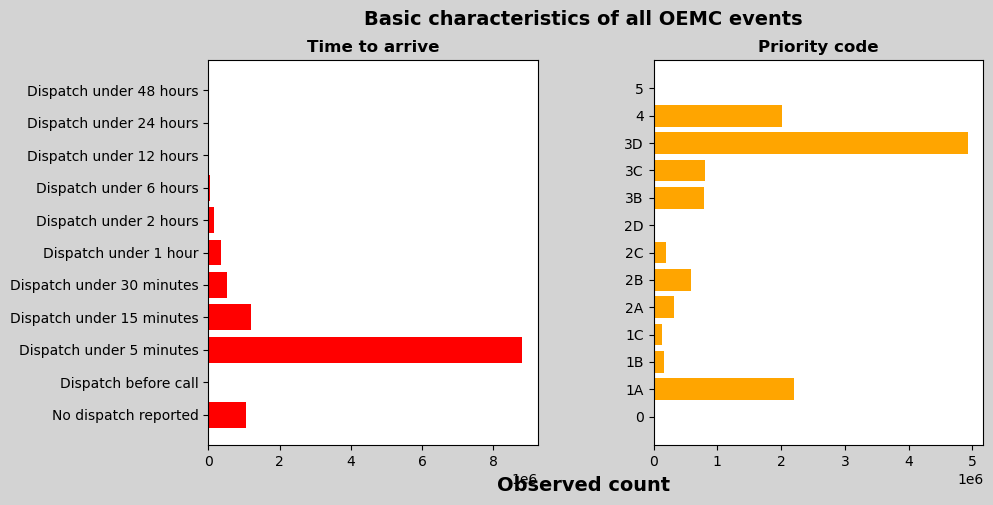

In [79]:
any_tta_vc = oemc_disp.tta_group.value_counts()
any_pri_vc = oemc_disp.init_priority.value_counts()
any_tta_y = [any_tta_vc[v] if v in any_tta_vc.keys() else 0 for v in ordered_tta]
any_pri_y = [any_pri_vc[v] if v in any_pri_vc.keys() else 0 for v in ordered_priority]

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 5),
                         facecolor='lightgray')
axs[0].barh(ordered_tta, any_tta_y, label='', color='red')
axs[0].set_title(label='Time to arrive', size=12, weight='bold')
axs[1].barh(ordered_priority, any_pri_y, color='orange')
axs[1].set_title(label='Priority code', size=12, weight='bold')
fig.suptitle('Basic characteristics of all OEMC events', size=14, weight='bold', )
fig.supxlabel('Observed count', size=14, weight='bold')
plt.subplots_adjust( wspace=0.35, hspace = 0.5 )
plt.show()

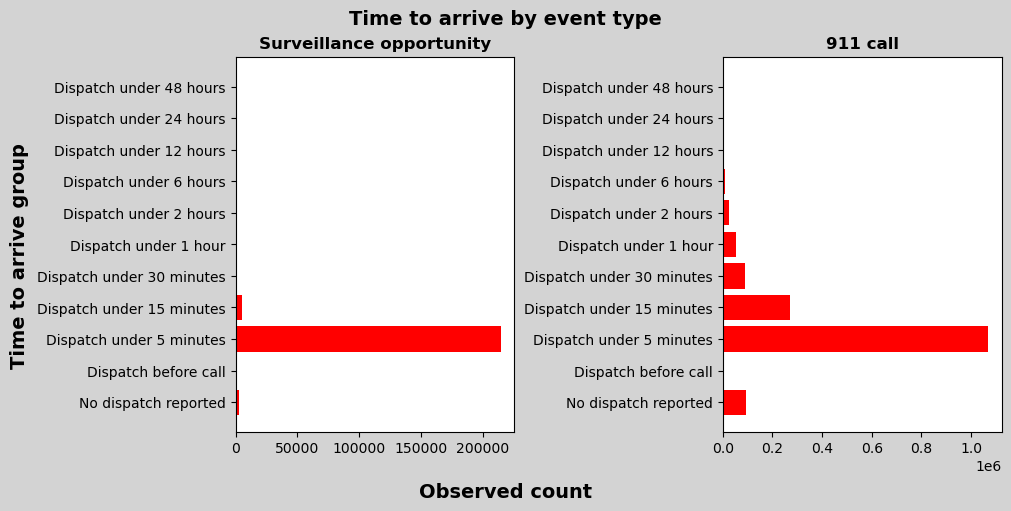

In [80]:
surveil_vc = oemc_disp.loc[oemc_disp.surveil, 'tta_group'].value_counts()
help_vc = oemc_disp.loc[oemc_disp.help, 'tta_group'].value_counts()
surveil_y = [surveil_vc[v] if v in surveil_vc.keys() else 0 for v in ordered_tta]
help_y = [help_vc[v] if v in help_vc.keys() else 0 for v in ordered_tta]

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 5),
                        layout="constrained", facecolor='lightgray')
axs[0].barh(ordered_tta, surveil_y, color='red')
axs[0].set_title(label='Surveillance opportunity', size=12, weight='bold')
axs[1].barh(ordered_tta, help_y, color='red')
axs[1].set_title(label='911 call', size=12, weight='bold')
fig.suptitle('Time to arrive by event type', size=14, weight='bold')
fig.supxlabel('Observed count', size=14, weight='bold')
fig.supylabel('Time to arrive group', size=14, weight='bold')
plt.show()

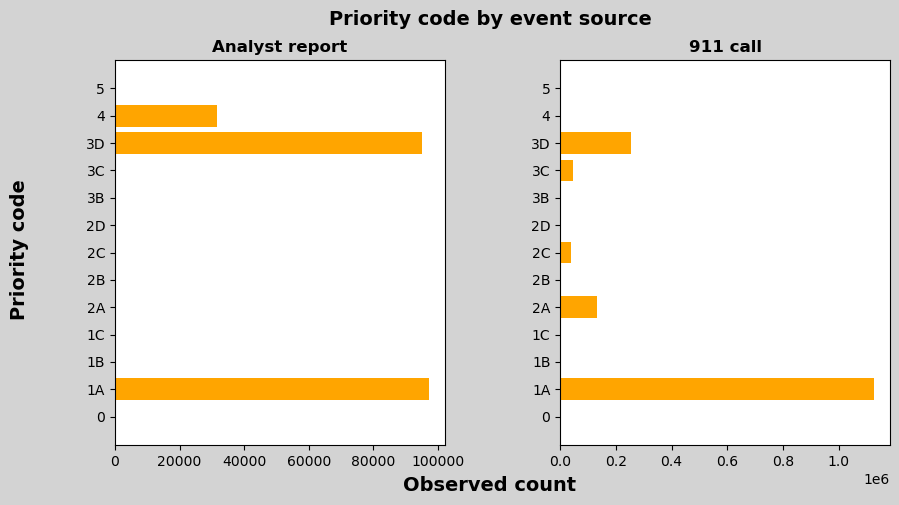

In [64]:
surveil_vc = oemc_disp.loc[oemc_disp.surveil, 'init_priority'].value_counts()
help_vc = oemc_disp.loc[oemc_disp.help, 'init_priority'].value_counts()
surveil_y = [surveil_vc[v] if v in surveil_vc.keys() else 0 for v in ordered_priority]
help_y = [help_vc[v] if v in help_vc.keys() else 0 for v in ordered_priority]

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 5),
                         facecolor='lightgray')
axs[0].barh(ordered_priority, surveil_y, color='orange')
axs[0].set_title(label='Analyst report', size=12, weight='bold')
axs[1].barh(ordered_priority, help_y, color='orange')
axs[1].set_title(label='911 call', size=12, weight='bold')
fig.suptitle('Priority code by event source', size=14, weight='bold', )
fig.supxlabel('Observed count', size=14, weight='bold')
fig.supylabel('Priority code', size=14, weight='bold')
plt.subplots_adjust( wspace=0.35, hspace = 0.5 )
plt.show()

# Conclusion

More analysis is needed to assess the relationship between priority code and whether dispatch is reported or how quickly, as well as the role district may play in whether dispatch is reported or how quickly.

- Broadly, 911 calls reviewed in this study received greater variability in response time compared to dispatch initiated by some surveillance technology such as ShotSpotter, HunchLab, PODs, or license plate scanners.
- A greater proportion of analyst reports are assigned priority 4 compared to the 911 calls analyzed. Priority 4 is one of the two codes that are meant to be referred to the rapid response unit according to CPD directives.